<a href="https://colab.research.google.com/github/iongie/demo-day-fin-8/blob/main/_Demo_day_Fintech_8_with_socioeconomy_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Demo day Fintech 8

"Data tersebut terkait dengan kampanye pemasaran langsung dari lembaga perbankan Portugis. Kampanye pemasaran didasarkan pada panggilan telepon. Seringkali, lebih dari satu kontak ke klien yang sama diperlukan, untuk mengakses apakah produk (deposito berjangka bank) akan ('ya') atau tidak ('tidak') dilanggan oleh pelanggan atau tidak. Folder data berisi dua kumpulan data: -

     train.csv: 45.211 baris dan 18 kolom diurutkan berdasarkan tanggal (dari Mei 2008 hingga November 2010)
     test.csv: 4521 baris dan 18 kolom dengan 10% contoh (4521), dipilih secara acak dari train.csv"

test pull and push

##Setup

In [1]:
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from google.colab import data_table
import tensorflow as tf
from sklearn.metrics import confusion_matrix

##Function

function split data

In [2]:
def dataframe_split(data, ratio= 0.2, shuffle= 0):
  len_ = int(len(data) - (ratio*len(data)))
  if shuffle == 0 :
    part_  = data.iloc[:int(1 + len_)]
    rest_part_ = data.drop(part_.index)
  elif shuffle == 1:
    part_ = data.sample(frac = 1.0 - ratio)
    rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

fucntion membuat dataset

In [3]:
def dataframe_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [4]:
def dataframe_imbalance_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  data = tf.data.Dataset.from_tensor_slices((dict(df), labels)).batch(batch_size)

  no_ds = (data
          .unbatch()
          .filter(lambda features, label: label==0)
          .repeat())
  yes_ds = (data
            .unbatch()
            .filter(lambda features, label: label==1)
            .repeat())
  
  ds = tf.data.Dataset.sample_from_datasets([no_ds, yes_ds], weights=[0.5, 0.5], stop_on_empty_dataset=True)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

function preprocessing numeric

In [5]:
def numeric_preprocessing(name, dataset, step):
  feature_dataset = dataset.map(lambda x,y: x[name])
  layer = tf.keras.layers.Normalization()
  layer.adapt(feature_dataset, steps=step)

  return layer

fucntion preprocessing categories

In [6]:
def categories_preprocessing(name, dataset, dtype, step):
  if(dtype == "int64"):
    lookup = tf.keras.layers.IntegerLookup()
  else:
    lookup = tf.keras.layers.StringLookup()
  feature_dataset = dataset.map(lambda x,y: x[name])
  lookup.adapt(feature_dataset, steps=step)

  # return lookup
  category_encoding = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  return lambda feature:  category_encoding(lookup(feature))

plot metric

In [7]:
def plot_metric(x, y, history, metric):
  fig, ax = plt.subplots(x, y, figsize=(15,10))
  epochs = range(len(history.history[metric[0]]))
  for metric, ax in zip(metric, ax.flatten()):
    ax.plot(epochs, history.history[metric], 'r', label='train')
    ax.plot(epochs, history.history['val_'+metric], 'b', ls="--", label='val')
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    ax.legend()  
  plt.show()

plot confution matrix

In [8]:
def plot_confution_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Tidak berlangganan diprediksi tidak berlangganan (True Negatives): ', cm[0][0])
  print('Tidak berlangganan diprediksi berlangganan (False Positives): ', cm[0][1])
  print('Berlangganan diprediksi tidak berlangganan (False Negatives): ', cm[1][0])
  print('Berlangganan diprediksi berlangganan (True Positives): ', cm[1][1])
  print('Total: ', np.sum(cm[1]))

## Mount Google Drive

In [ ]:
drive.mount('/content/drive')

## Load Data

In [ ]:
data_url = "/content/drive/MyDrive/Kumpulan_dataset/fintech_banking_dataset.zip"
data_dir = zipfile.ZipFile(data_url, 'r')
data_dir.extractall("demoday")
data_dir.close()

In [ ]:
# dataset_train=pd.read_csv('demoday/train.csv', delimiter=";")
# dataset_test=pd.read_csv('demoday/test.csv', delimiter=";")

In [ ]:
# dataset_train=pd.read_csv('train.csv', delimiter=";")
# dataset_test=pd.read_csv('test.csv', delimiter=";")
# dataset_additional=pd.read_csv('bank-additional.csv', delimiter=";")
# dataset_additional_full=pd.read_csv('bank-additional-full.csv', delimiter=";")
# dataset_bank=pd.read_csv('bank.csv', delimiter=";")
# dataset_bank_full=pd.read_csv('bank_full.csv', delimiter=";")

In [10]:
dataset_train=pd.read_csv('bank-additional-full.csv', delimiter=";")
dataset_test=pd.read_csv('bank-additional.csv', delimiter=";")

In [11]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [12]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

##Deskripsi dataset
###Input variables:
bank client data:  
1 - age : umur pelanggan (numeric)  
2 - job : jenis pekerjaan (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')  
3 - marital : status pernikahan (categorical: 'divorced','married','single','unknown'; note: 'divorced' berarti cerai atau janda)  
4 - education : tingkat pendidikan(categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')  
5 - default: apakah memiliki kredit yang gagal bayar? (categorical: 'no','yes','unknown')  
6 - housing: apakah memiliki pinjaman untuk rumah? (categorical: 'no','yes','unknown')  
7 - loan: apakah memiliki pinjaman untuk pribadi? (categorical: 'no','yes','unknown')  
related with the last contact of the current campaign:  
8 - contact: jenis komunikasi kontak (categorical: 'cellular','telephone')  
9 - month: kontak terakhir bulan tahun (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')  
10 - day_of_week: hari kontak terakhir dalam seminggu (categorical: 'mon','tue','wed','thu','fri')  
11 - duration: durasi kontak terakhir, dalam detik (numeric)  
other attributes:  
12 - campaign: jumlah kontak yang dilakukan selama kampanye ini dan untuk klien ini (numeric, includes last contact)  
13 - pdays: jumlah hari yang berlalu setelah klien terakhir dihubungi dari kampanye sebelumnya (numeric; 999 artinya klien sebelumnya tidak dihubungi)  
14 - previous: jumlah kontak yang dilakukan sebelum kampanye ini dan untuk klien ini (numeric)  
15 - poutcome: hasil dari kampanye pemasaran sebelumnya (categorical: 'failure','nonexistent','success')  
social and economic context attributes  
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
17 - cons.price.idx: consumer price index - monthly indicator (numeric)  
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
20 - nr.employed: number of employees - quarterly indicator (numeric)  
###Output variable (desired target):
21 - y - apakah klien telah berlangganan deposito berjangka?? (binary: 'yes','no')  
Source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing  

##Data Explorer

In [13]:
print(f"jumlah data untuk train adalah {len(dataset_train)}")
print(f"jumlah data untuk test adalah {len(dataset_test)}")

jumlah data untuk train adalah 41188
jumlah data untuk test adalah 4119


In [14]:
dataset_test.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [15]:
dataset_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


melihat type pada data set

In [16]:
dataset_train.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [17]:
train_index = [i for i in dataset_train.drop(columns=['y']).columns]
dataset_train.groupby(by=train_index)["y"].value_counts().unstack().reset_index().sort_values(by=["no"], ascending=True).head()

y,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,no,yes
1,17,student,single,basic.9y,no,yes,no,cellular,aug,fri,...,4,2,success,-2.9,92.201,-31.4,0.869,5076.2,1.0,NaN
27391,44,admin.,married,university.degree,no,yes,yes,cellular,jul,mon,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,1.0,NaN
27390,44,admin.,married,university.degree,no,yes,yes,cellular,apr,fri,...,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,1.0,NaN
27388,44,admin.,married,university.degree,no,yes,no,telephone,may,wed,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,1.0,NaN
27387,44,admin.,married,university.degree,no,yes,no,telephone,may,wed,...,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,1.0,NaN


In [18]:
cek_no_yes_max = dataset_train.groupby(by=["age", "job", "marital", "education", "housing", "loan", "month" , "duration"])["y"].value_counts().unstack().reset_index()

In [19]:
cek_no_yes_max.loc[cek_no_yes_max['no'].ge(1.0) &cek_no_yes_max['yes'].ge(1.0)]

y,age,job,marital,education,housing,loan,month,duration,no,yes
4366,29,admin.,married,university.degree,yes,yes,apr,245,1.0,1.0
5750,30,admin.,married,university.degree,no,no,aug,139,1.0,1.0
8095,31,blue-collar,married,basic.9y,no,no,may,535,1.0,1.0
9779,32,admin.,single,university.degree,yes,no,jul,210,1.0,1.0
19074,37,management,married,university.degree,yes,no,jul,292,1.0,1.0
22260,39,technician,married,professional.course,no,no,apr,225,1.0,1.0
40702,73,retired,married,university.degree,yes,no,mar,179,1.0,1.0


In [20]:
col_clean_outliers = ['campaign']
for col in col_clean_outliers:
  Q1 = dataset_train[col].quantile(0.25)
  Q3 = dataset_train[col].quantile(0.75)
  IQR = Q3 - Q1
  scale = 1
  # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
  dataset_train = dataset_train.query(f'(@Q1 - {scale} * @IQR) <= {col} <= (@Q3 + {scale} * @IQR)')

##Data Preparation

mengubah column y, dengan nilai 0 menunjukan *NO* dan nilai 1 menunjukan *YES*

In [21]:
# drop_columns = ["contact",	"day_of_week", "month", "campaign", "poutcome", "y"]
drop_columns = ["contact",	"day_of_week", "month", "poutcome", "y"]

dataset_train['target'] = dataset_train.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)
dataset_train.drop(columns=drop_columns, inplace=True)

dataset_test['target'] = dataset_test.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)
dataset_test.drop(columns=drop_columns, inplace=True)

dataset train ini merupakan dataframe pandas, split data train dengan ratio 80:20 . 20 % untuk validasi

In [22]:
train, val = dataframe_split(dataset_train, ratio = 0.2, shuffle=1)

In [23]:
print(len(train), 'training examples')
print(len(val), 'validation examples')

30242 training examples
7561 validation examples


##Data Preprocessing

membuat dataset

In [24]:
batch_size = 1024
step = 128

train_ds = dataframe_imbalance_to_dataset(train, batch_size=batch_size)
val_ds = dataframe_imbalance_to_dataset(val, batch_size=batch_size)
test_ds = dataframe_to_dataset(dataset_test, batch_size=batch_size)

cek data

In [25]:
for features, labels in train_ds.take(1):
  print(labels.numpy())

[1 0 1 ... 1 1 1]


In [26]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of marital:', train_features['job'])
print('A batch of targets:', label_batch )

Every feature: ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
A batch of marital: tf.Tensor(
[[b'self-employed']
 [b'admin.']
 [b'management']
 ...
 [b'admin.']
 [b'admin.']
 [b'self-employed']], shape=(1024, 1), dtype=string)
A batch of targets: tf.Tensor([0 0 0 ... 1 1 1], shape=(1024,), dtype=int64)


In [ ]:
# test_job_col = train_features['job']
# test_job_layer = categories_preprocessing(name='job',
#                                         dataset=train_ds,
#                                         dtype='string',
#                                         step=step)
# test_job_layer(test_job_col).numpy()

In [ ]:
# test_duration_col = train_features['duration']
# test_duration_layer = numeric_preprocessing(name='duration',
#                                             dataset=train_ds,
#                                             step=step)
# test_duration_layer(test_duration_col)

membagikan column berdasarkan numeric atau categorical integer atau string

In [53]:
# numeric_keys = ["balance", "duration"]
numeric_keys = ["emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"]
categorical_integer_keys = ["age", "campaign", "pdays", "previous"]
categorical_string_keys = ["job", "marital", "education", "housing", "loan"]
all_inputs = []
all_preprocessors = []

In [54]:
for numeric in numeric_keys:
  input = tf.keras.Input(shape=(1,), name=numeric, dtype="int64")
  num_layer = numeric_preprocessing(name=numeric, dataset=train_ds, step=step)
  num_preprocessor = num_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(num_preprocessor)

In [55]:
for categorical in categorical_string_keys:
  input = tf.keras.Input(shape=(1,), name=categorical, dtype="string")
  cat_layer = categories_preprocessing(name=categorical, dataset=train_ds, dtype="string", step=step)
  cat_preprocessor = cat_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_preprocessor)

In [56]:
for categorical_int in categorical_integer_keys:
  input = tf.keras.Input(shape=(1,), name=categorical_int, dtype="int64")
  cat_int_layer = categories_preprocessing(name=categorical_int, dataset=train_ds, dtype="int64", step=step)
  cat_int_preprocessor = cat_int_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_int_preprocessor)

In [57]:
all_inputs, all_preprocessors

([<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'emp.var.rate')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'cons.price.idx')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'cons.conf.idx')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'euribor3m')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'nr.employed')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'job')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'marital')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'education')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'housing')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'loan')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'campaign')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'pdays')>,
  <Ker

##Model

In [58]:
all_features = tf.keras.layers.concatenate(all_preprocessors)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(16, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(all_inputs, output)

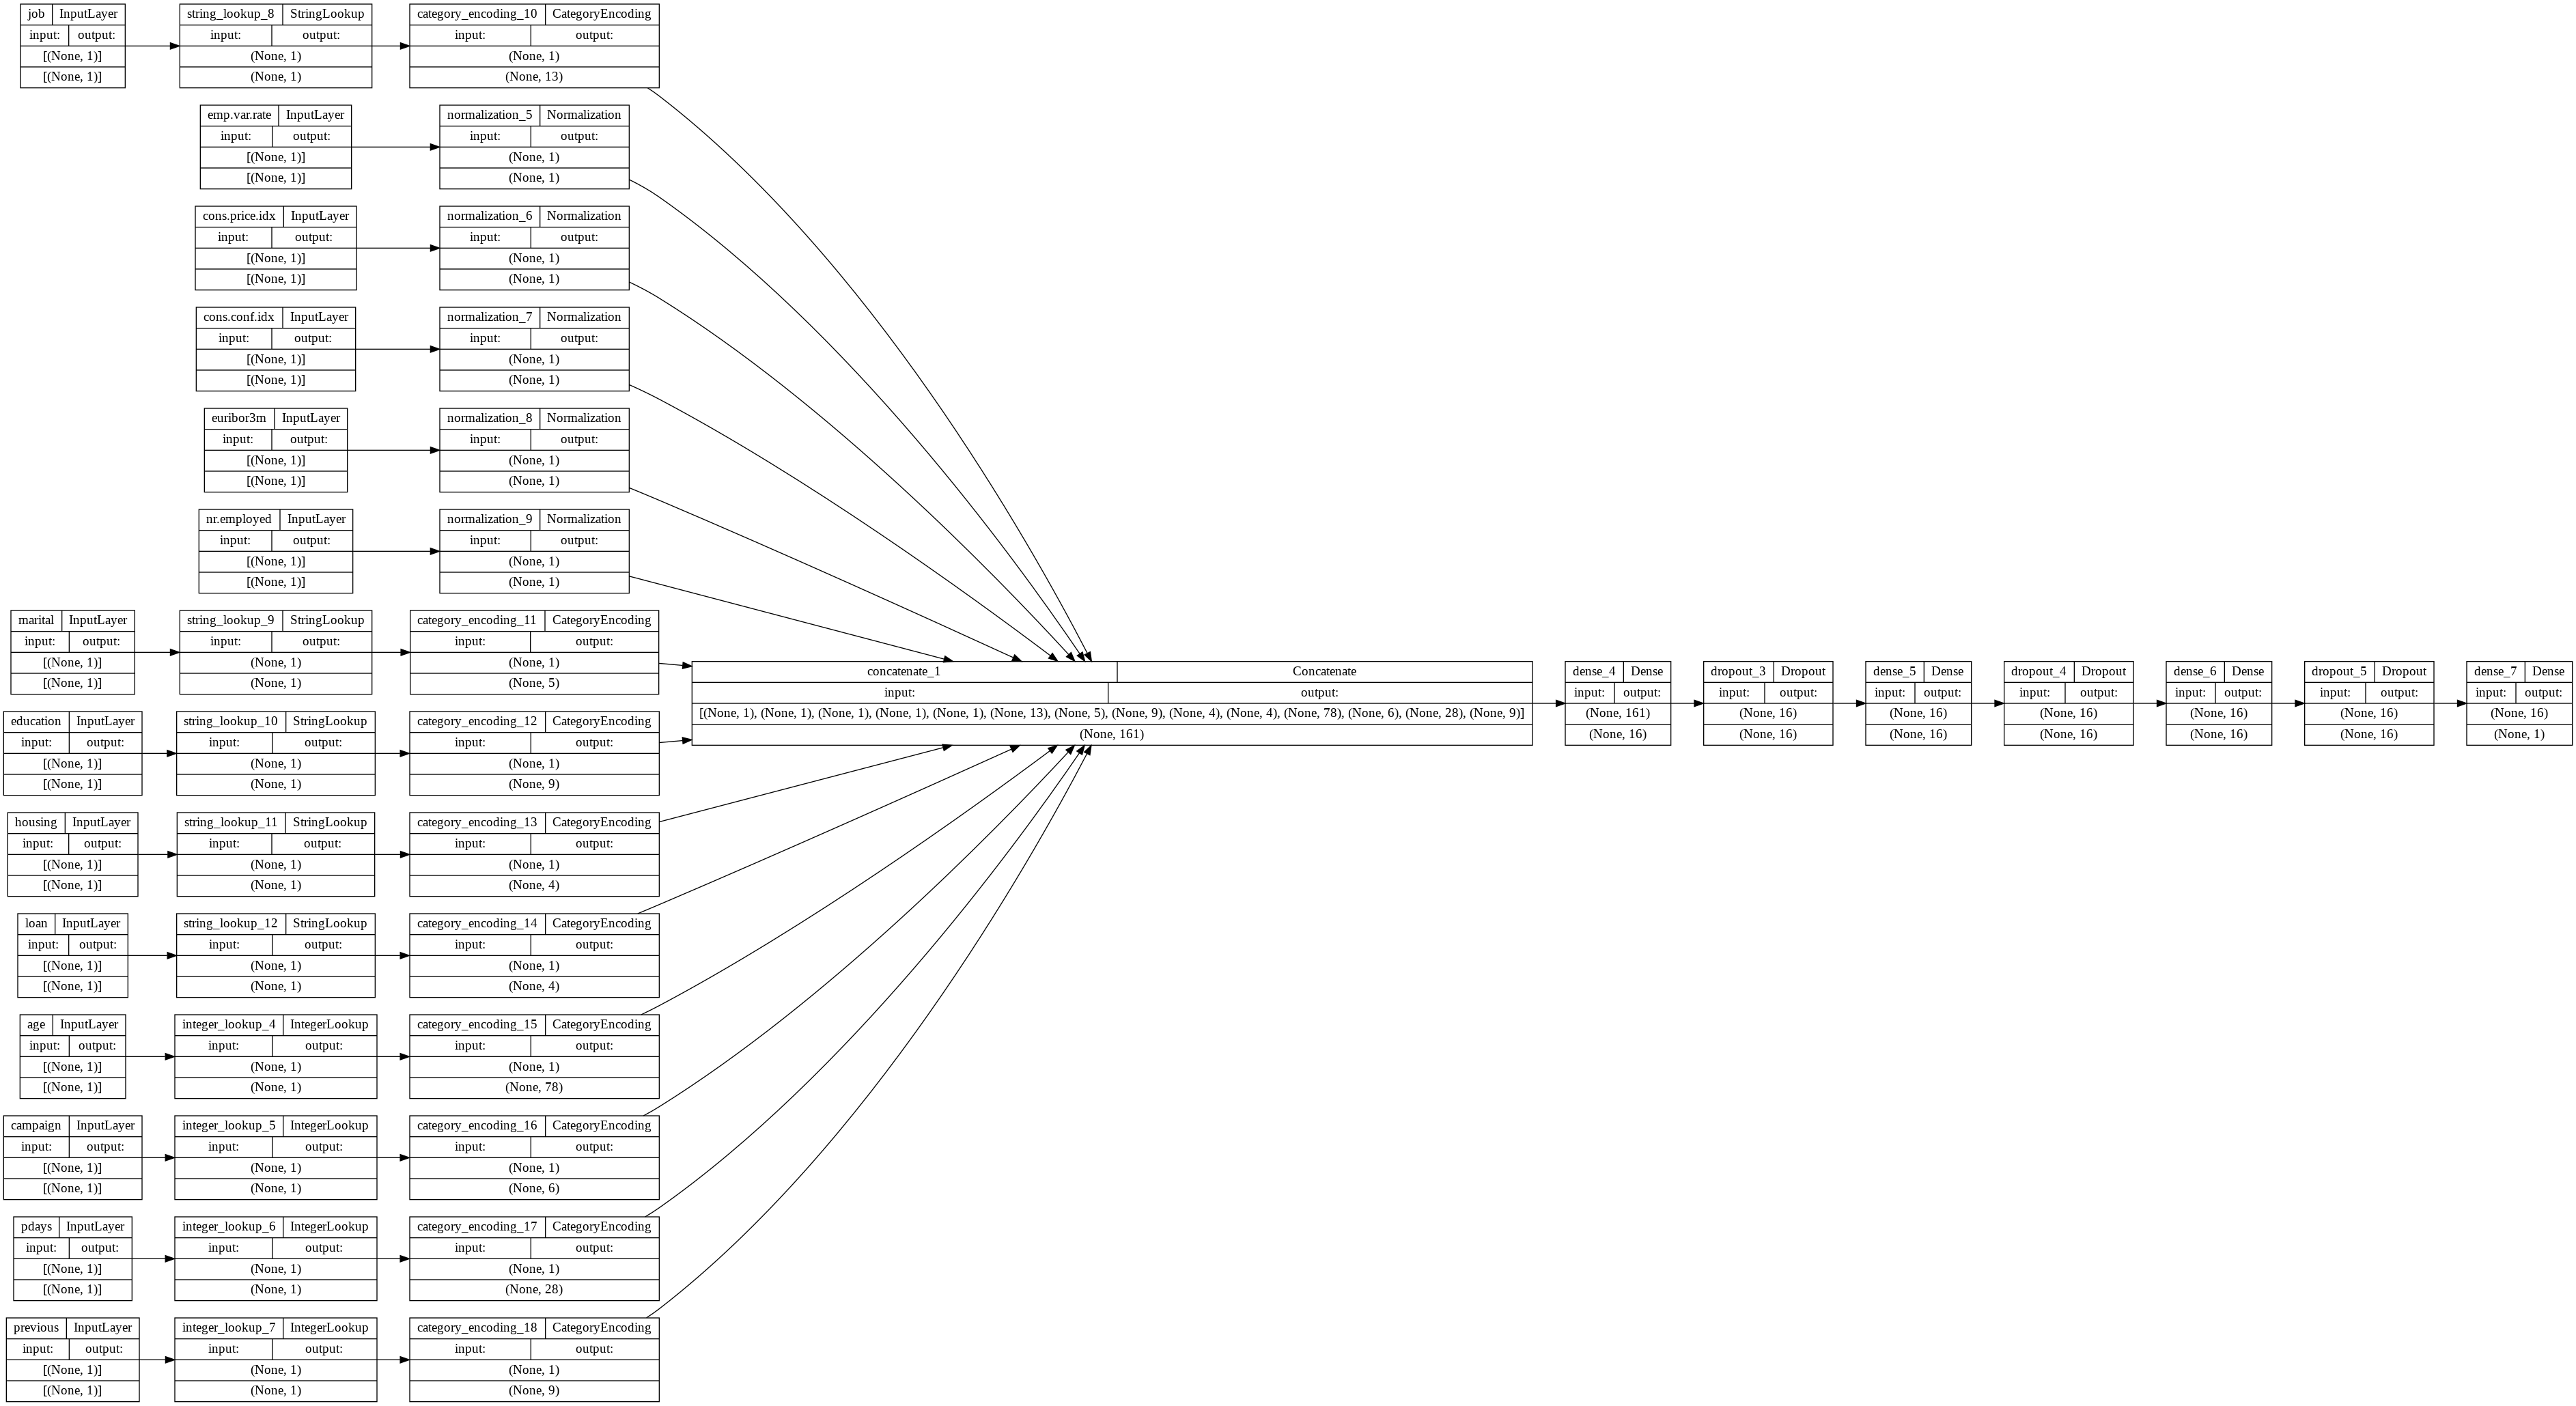

In [59]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [60]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')
]
model.compile(optimizer=tf.keras.optimizers.Adam(amsgrad=True),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [61]:
loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
val_loss = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(train_ds, epochs=100, validation_data=val_ds, validation_steps=32, callbacks=[loss, val_loss], steps_per_epoch=32)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['default', 'duration'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


32/32 [==============================] - 21s 594ms/step - loss: 0.6842 - tp: 9833.0000 - fp: 8556.0000 - tn: 7752.0000 - fn: 6627.0000 - accuracy: 0.5367 - precision: 0.5347 - recall: 0.5974 - auc: 0.5643 - val_loss: 0.6569 - val_tp: 9995.0000 - val_fp: 2528.0000 - val_tn: 13941.0000 - val_fn: 6304.0000 - val_accuracy: 0.7305 - val_precision: 0.7981 - val_recall: 0.6132 - val_auc: 0.7698
Epoch 2/100
32/32 [==============================] - 18s 568ms/step - loss: 0.6622 - tp: 9190.0000 - fp: 6213.0000 - tn: 10263.0000 - fn: 7102.0000 - accuracy: 0.5937 - precision: 0.5966 - recall: 0.5641 - auc: 0.6356 - val_loss: 0.6225 - val_tp: 10250.0000 - val_fp: 2325.0000 - val_tn: 13970.0000 - val_fn: 6223.0000 - val_accuracy: 0.7391 - val_precision: 0.8151 - val_recall: 0.6222 - val_auc: 0.7781
Epoch 3/100
32/32 [==============================] - 18s 590ms/step - loss: 0.6413 - tp: 8454.0000 - fp: 3955.0000 - tn: 12436.0000 - fn: 7923.0000 - accuracy: 0.6375 - precision: 0.6813 - recall: 0.5162 

##Model Evaluation

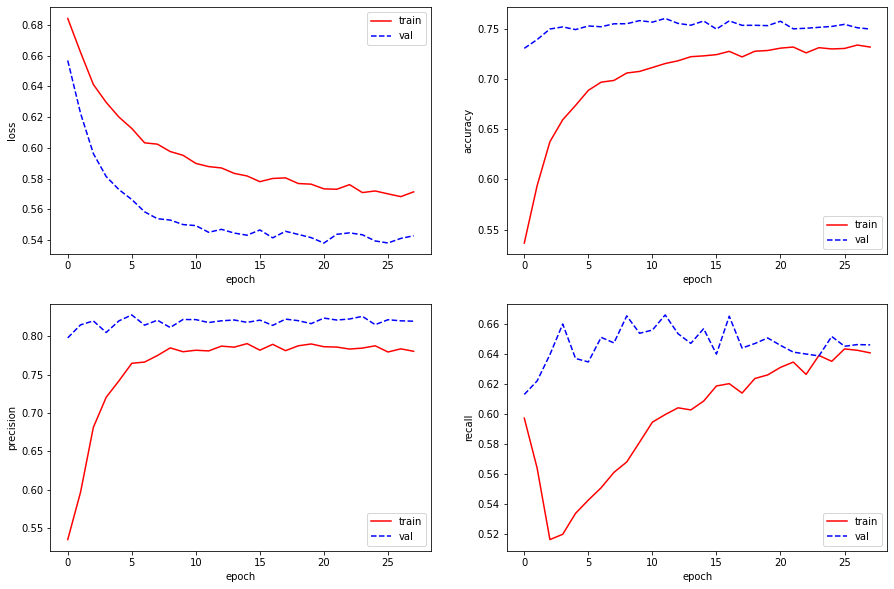

In [62]:
metric = ['loss', 'accuracy', 'precision', 'recall']
plot_metric(2,2, history, metric)

In [63]:
predict_test = model.predict(test_ds)
test_ds_unbach = test_ds.unbatch()
label_test = [i[1] for i in list(test_ds_unbach.as_numpy_iterator())]

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['default', 'duration'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [64]:
len(predict_test)

4119

5/5 [==============================] - 0s 26ms/step - loss: 0.5127 - tp: 287.0000 - fp: 599.0000 - tn: 3069.0000 - fn: 164.0000 - accuracy: 0.8148 - precision: 0.3239 - recall: 0.6364 - auc: 0.7880
loss :  0.5126903653144836
tp :  287.0
fp :  599.0
tn :  3069.0
fn :  164.0
accuracy :  0.8147608637809753
precision :  0.32392776012420654
recall :  0.6363636255264282
auc :  0.7880198359489441
Tidak berlangganan diprediksi tidak berlangganan (True Negatives):  3069
Tidak berlangganan diprediksi berlangganan (False Positives):  599
Berlangganan diprediksi tidak berlangganan (False Negatives):  164
Berlangganan diprediksi berlangganan (True Positives):  287
Total:  451


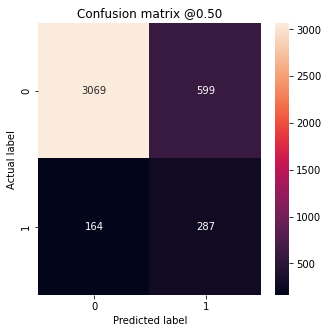

In [65]:
model_evaluate = model.evaluate(test_ds)
for name_metric, value_evaluate in zip(model.metrics_names, model_evaluate):
  print(name_metric, ': ', value_evaluate)

plot_confution_matrix(label_test, predict_test)

Tidak berlangganan diprediksi tidak berlangganan (True Negatives):  713
Tidak berlangganan diprediksi berlangganan (False Positives):  2955
Berlangganan diprediksi tidak berlangganan (False Negatives):  22
Berlangganan diprediksi berlangganan (True Positives):  429
Total:  451


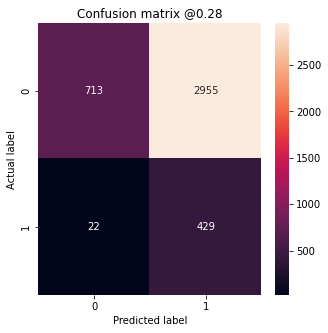

In [77]:
plot_confution_matrix(label_test, predict_test, p=0.285)

Dari 4119 pelanggan, 713 nya berhasil diprediksi tidak akan berlangganan. Dengan begitu, dengan menggunakan model ini kita dapat mengurangi jumlah kampanye sebesar 17%. Tetapi terdapat kesalahan dimana yang berlangganan diprediksi tidak akan berlangganan sebesar 4.8%. Dengan begitu, threshold yang dirasa dapat memaksimalkan profit adalah di 0.285 (dengan asumsi False Negative maksimal 5%).

In [68]:
dataset_test.sort_values(by=["target"], ascending=True).head()

,age,job,marital,education,default,housing,loan,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
0,30,blue-collar,married,basic.9y,no,yes,no,487,2,999,0,-1.8,92.893,-46.2,1.313,5099.1,0
2660,43,blue-collar,married,basic.9y,unknown,yes,no,545,1,999,0,-1.8,92.893,-46.2,1.344,5099.1,0
2662,33,management,married,university.degree,no,no,no,191,3,999,0,1.4,93.444,-36.1,4.965,5228.1,0
2663,40,admin.,single,high.school,no,no,no,97,1,999,0,1.4,94.465,-41.8,4.967,5228.1,0
2664,58,blue-collar,married,basic.4y,unknown,yes,no,86,2,999,0,1.4,93.918,-42.7,4.960,5228.1,0


##Simulation

In [81]:
sample = {
    'age': 30,
    'job': 'blue-collar',
    'marital': 'married',
    'education': 'basic.9y',
    'default':'no',
    'housing': 'yes',
    'loan': 'no',
    'campaign':2,
    'pdays':999,
    'previous':0,
    'poutcome':'nonexistent',
    "emp.var.rate":-1.8,
    "cons.price.idx":92.893, 
    "cons.conf.idx":-46.2, 
    "euribor3m":1.313, 
    "nr.employed":5099.1
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    f"Probabilitas untuk berlangganan deposito berjangka adalah {round(100 * predictions[0][0], 2)} % "
    f"untuk setuju"
)

Probabilitas untuk berlangganan deposito berjangka adalah 39.28 % untuk setuju
